In [81]:
import nltk
import pandas as pd
import re
import numpy as np
from textblob_de import TextBlobDE as TextBlob

from collections import Counter
from pattern.text import de

names = list()
speech = list()

with open("Bundestag-2018-02-21.txt", "r") as file:
    inSpeech = False
    thisSpeech = ""
    
    for line in file:
        line = line.strip()
        # : is the last sign in all name lines
        if (":" in line[len(line) - 1:]):
            # people are either ministers (,) or MPs ( ( ) or Vice president or president
            if ("," in line or "(" in line or "Präsident" in line or "Vizepräsident" in line):
                # sometimes the floor is passed to another person, filter out those lines as well
                if (not ("!" in line or re.match("Ich(\s)", line) or re.search("(\s)ich(\s)", line))):
                    speech.append(thisSpeech)
                    thisSpeech = ""
                    names.append(line)
                    inSpeech = True
                    continue
                    
        # end of the session 
        if ("(Schluss:" in line):
            speech.append(thisSpeech)
            break
        # append the line to the previous speech line
        # same person is speaking
        if (inSpeech):
            thisSpeech = thisSpeech + line

# convert to dataframe
speeches = pd.DataFrame({"names":names,"speech":speech[1:]})
#print(speeches.head())

In [82]:
# Ideas:
# - length of speeches compare to number of speeches
# - sentiment in speech (very positive, very negative
# - asks a lot of questions

# take first idea and compare length of speech with number of speeches
# create a data-structure which include: name, number of speeches, all speeches merged together

MPs = set(speeches.names)

summary = pd.DataFrame(index=list(MPs),columns=["text","speech","num"])

for member in MPs:
    thisSpeech = speeches[speeches.names == member].speech
    textSpeech = ' '.join(thisSpeech.tolist())
    txt = TextBlob(textSpeech)
    summary.loc[member] = pd.Series({"text":textSpeech,"speech":txt,"num":len(thisSpeech)})

# summary now contains the text and the number of times the MP has spoken
#print(summary.head())

In [83]:
# nest step: lexical Diversity
def lexicalDiversity(txt):
    return len(txt.words)/len(set(txt.words))

def PartyExtractor(txt):
    if("(" in txt):
        return txt[txt.index("(")+1:txt.index(")")]
    else:
        return np.NaN

summary["diversity"]= summary["speech"].apply(lexicalDiversity)

summary["precision"] = summary["text"].apply(len)/summary["num"]

summary["party"] = pd.Series(index=summary.index,data=summary.index).apply(PartyExtractor)


In [77]:
parties = set(summary.party)
parties = [x for x in parties if isinstance(x,str)]

sentimentSummary = pd.DataFrame(index=parties,columns=["positive","neutral","negative"])
import math
for x in parties:
#    if(not isinstance(x,str)):
#        continue
    partySpeeches = summary[summary.party==x]
    blob =TextBlob(' '.join(partySpeeches.text))
    polarity = list()
    subjectivity = list()
    for y in blob.sentences:
        thisSentiment = y.sentiment
        polarity.append(thisSentiment[0])
        subjectivity.append(thisSentiment[1])
    sentimentSummary.loc[x] = {"positive":len(list(filter(lambda x:(x>0),polarity)))/len(polarity),
                               "negative":len(list(filter(lambda x:(x<0),polarity)))/len(polarity),
                               "neutral":len(list(filter(lambda x:(x==0),polarity)))/len(polarity)}
print(sentimentSummary)

                       positive   neutral  negative
SPD                    0.213675  0.521368  0.264957
DIE LINKE              0.141304  0.521739  0.336957
CDU/CSU                0.265403  0.563981  0.170616
FDP                    0.166667  0.653846  0.179487
AfD                     0.16568  0.609467  0.224852
BÜNDNIS 90/DIE GRÜNEN  0.291667       0.6  0.108333


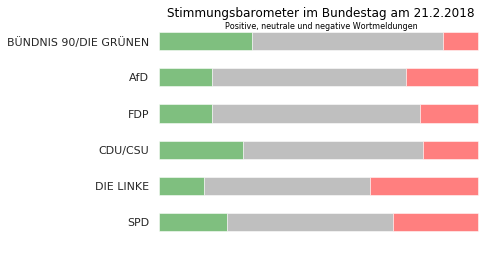

In [80]:
# display the data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("white",{"text.color":"0"})
ax=sentimentSummary.plot(kind="barh",
                         stacked=True,
                         color=['green', 'grey', 'red'],
                         alpha=0.5,
                         legend=False)
ax.tick_params(axis="x",colors="white")
plt.figtext(0.5,0.9,"Stimmungsbarometer im Bundestag am 21.2.2018", fontsize="12", ha="center")
plt.figtext(0.5,0.86,"Positive, neutrale und negative Wortmeldungen", fontsize="8", ha="center")
sns.despine(top=True,left=True,right=True,bottom=True)
ax.get_figure().savefig('bar.png',bbox_inches="tight")